In [1]:
import numpy as np
import pandas as pd
import os
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import defaultdict

In [3]:
#Create Files

def read_files_into_dataframe(directory_path):
    
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        if os.path.isfile(file_path) and filename.endswith('txt'):
            df = pd.read_csv(file_path, delimiter='\t', header=None)
            df.columns = ['journal', 'title', 'authors', 'year', 'abstract']
            df_name = filename.rsplit('.', 1)[0] + 'df'
            globals()[df_name] = df



In [4]:
#Create Dataframes

directory = r'..\Data\topic-paper-author\Cross-Domain_data'
dataframes = read_files_into_dataframe(directory)

In [5]:
theorydf

,journal,title,authors,year,abstract
0,FOCS,Parallel Linear Programming in Fixed Dimension...,"Noga Alon,Nimrod Megiddo",1990,"It is shown that, for any fixed dimension d, t..."
1,FOCS,Coin-Flipping Games Immune against Linear-Size...,"Noga Alon,Moni Naor",1990,Coin-Flipping Games Immune against Linear-Size...
2,FOCS,A Time-Space Tradeoff for Boolean Matrix Multi...,Karl R. Abrahamson,1990,A time-space tradeoff is established in the br...
3,FOCS,A Markovian Extension of Valiant's Learning Mo...,"David Aldous,Umesh V. Vazirani",1990,A Markovian Extension of Valiant's Learning Mo...
4,FOCS,An Approach for Proving Lower Bounds: Solution...,"Ding-Zhu Du,Frank K. Hwang",1990,A family of finitely many continuous functions...
...,...,...,...,...,...
3990,STOC,Worst-case update times for fully-dynamic all-...,Mikkel Thorup,2005,We present here the first solution to the full...
3991,STOC,On uniform amplification of hardness in NP.,Luca Trevisan,2005,We continue the study of amplification of aver...
3992,STOC,An O(log n log log n) space algorithm for undi...,Vladimir Trifonov,2005,We present a deterministic O(log n log log n) ...
3993,STOC,Tensor decomposition and approximation schemes...,"Wenceslas Fernandez de la Vega,Marek Karpinski...",2005,The only general class of MAX-rCSP problems fo...


In [9]:
#Years

dfs = [databasedf, dataminingdf, medicalinformaticsdf, theorydf, visualizationdf]

for x in dfs:
    print(x['year'].min(), x['year'].max())
    print(x['journal'].ndistinct)

1990 2005
1994 2005
1990 2005
1990 2005
1990 2005


In [14]:
#Distinct Journals

totaljournallist=[]
for x in dfs:
    totaljournallist.append(x['journal'].unique())

totaljournallistflat = list(set([item for sublist in totaljournallist for item in sublist]))

print(len(totaljournallistflat))

22


In [35]:
#Build Graph

dfs = [databasedf, dataminingdf, medicalinformaticsdf, theorydf, visualizationdf]

G = nx.Graph()
publication_count = defaultdict(int)

def build_coauthorship_graph(dfs, max_rows=500):
    row_counter = 0
    
    for df in dfs:
        for index, row in df.iterrows():
            if row_counter >= max_rows:
                break

            if pd.notna(row['authors']):
                authors = [author.strip() for author in row['authors'].split(',')]

                for author in authors:
                    publication_count[author] += 1
                for author_pair in itertools.combinations(authors, 2):
                    if G.has_edge(author_pair[0], author_pair[1]):
                        G[author_pair[0]][author_pair[1]]['weight'] += 1
                    else:
                        G.add_edge(author_pair[0], author_pair[1], weight=1)

            row_counter += 1

        if row_counter >= max_rows:
            break


build_coauthorship_graph(dfs, max_rows=1000)

C:\Users\snuga\AppData\Local\Temp\ipykernel_16320\481899277.py:19: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors)


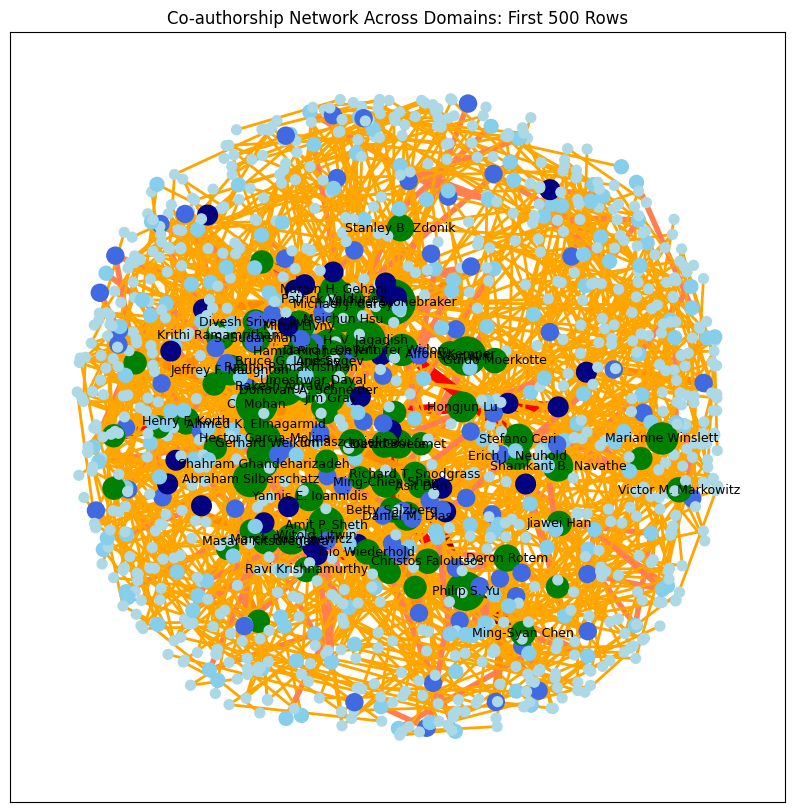

In [45]:
#Draw Graph

node_sizes = [publication_count[author] * 50 for author in G.nodes()]

node_color_map = {1: 'lightblue', 2: 'skyblue', 3: 'royalblue', 4: 'navy', 5: 'green'}
node_colors = [node_color_map[min(publication_count[author], 5)] for author in G.nodes()]

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=0.3)

node_sizes = [publication_count[author] * 50 for author in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)


edge_color_map = {1: 'orange', 2: 'coral', 3: 'darkorange', 4: 'red', 5: 'darkred'}
edge_colors = [edge_color_map[min(d['weight'], 5)] for (u, v, d) in G.edges(data=True)]

edge_widths = [d['weight'] * 2 for (u, v, d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors)


labels = {author: author for author in G.nodes() if publication_count[author] > 5}
nx.draw_networkx_labels(G, pos, labels, font_size=9)

plt.title("Co-authorship Network Across Domains: First 500 Rows")
plt.show()